In [83]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline

from datetime import datetime
import yfinance as yf

# The tech stocks we'll use for this analysis
tech_list = ['AAPL', 'GOOG', 'MSFT', 'AMZN']

# Set up End and Start times for data grab
end = datetime.now()
start = datetime(end.year - 1, end.month, end.day)

# Fetch the stock data
company_data = {}

for stock in tech_list:
    company_data[stock] = yf.download(stock, start=start, end=end,actions=False)

# Add company name to each DataFrame and concatenate into a single DataFrame
company_list = [company_data[stock] for stock in tech_list]
company_name = ["APPLE", "GOOGLE", "MICROSOFT", "AMAZON"]

for df, name in zip(company_list, company_name):
    df["company_name"] = name

df = pd.concat(company_list, axis=0)
print(df.tail(10))


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2024-07-18  189.589996  189.679993  181.449997  183.750000  183.750000   
2024-07-19  181.139999  184.929993  180.110001  183.130005  183.130005   
2024-07-22  185.000000  185.059998  182.479996  182.550003  182.550003   
2024-07-23  184.100006  189.389999  183.559998  186.410004  186.410004   
2024-07-24  183.199997  185.449997  180.410004  180.830002  180.830002   
2024-07-25  182.910004  183.899994  176.800003  179.850006  179.850006   
2024-07-26  180.389999  183.190002  180.240005  182.500000  182.500000   
2024-07-29  183.839996  184.750000  182.380005  183.199997  183.199997   
2024-07-30  184.720001  185.860001  179.380005  181.710007  181.710007   
2024-07-31  184.970001  187.940002  184.460007  186.979996  186.979996   

              Volume company_name  
Date                               
2024-07-18  51043600       AMAZON  
202

In [85]:
# imports 
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline

from datetime import datetime
import yfinance as yf

# The tech stocks we'll use for this analysis
tech_list = ['AAPL', 'GOOG', 'MSFT', 'AMZN']

# Set up End and Start times for data grab
end = datetime.now()
start = datetime(end.year - 5, end.month, end.day)

# Fetch the stock data
company_data = {}

for stock in tech_list:
    company_data[stock] = yf.download(stock, start=start, end=end)

# Add company name to each DataFrame and concatenate into a single DataFrame
company_list = [company_data[stock] for stock in tech_list]
company_name = ["APPLE", "GOOGLE", "MICROSOFT", "AMAZON"]

for df, name in zip(company_list, company_name):
    df["company_name"] = name

df = pd.concat(company_list, axis=0)

# Print example of the first 10 stocks
print(df.tail(10))

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2024-07-18  189.589996  189.679993  181.449997  183.750000  183.750000   
2024-07-19  181.139999  184.929993  180.110001  183.130005  183.130005   
2024-07-22  185.000000  185.059998  182.479996  182.550003  182.550003   
2024-07-23  184.100006  189.389999  183.559998  186.410004  186.410004   
2024-07-24  183.199997  185.449997  180.410004  180.830002  180.830002   
2024-07-25  182.910004  183.899994  176.800003  179.850006  179.850006   
2024-07-26  180.389999  183.190002  180.240005  182.500000  182.500000   
2024-07-29  183.839996  184.750000  182.380005  183.199997  183.199997   
2024-07-30  184.720001  185.860001  179.380005  181.710007  181.710007   
2024-07-31  184.970001  187.940002  184.460007  186.979996  186.979996   

              Volume company_name  
Date                               
2024-07-18  51043600       AMAZON  
202

In [87]:
# Describe the dataset statistically 
print(company_data['AAPL'].describe())

              Open         High          Low        Close    Adj Close  \
count  1259.000000  1259.000000  1259.000000  1259.000000  1259.000000   
mean    139.534738   141.099132   138.074061   139.652226   138.051243   
std      42.121174    42.409793    41.820653    42.113134    42.535096   
min      48.852501    49.517502    48.145000    48.334999    46.647980   
25%     118.680000   120.110001   116.629997   118.665001   116.299282   
50%     146.830002   148.449997   145.300003   146.800003   144.861069   
75%     171.754997   173.615005   170.514999   172.154999   170.622597   
max     236.479996   237.229996   233.089996   234.820007   234.820007   

             Volume  
count  1.259000e+03  
mean   9.576907e+07  
std    5.243688e+07  
min    2.404830e+07  
25%    6.091975e+07  
50%    8.182120e+07  
75%    1.124566e+08  
max    4.265100e+08  


In [89]:
# Describe concisely the features,
# including the number of non-null values and data types
print(company_data['AAPL'].info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1259 entries, 2019-07-31 to 2024-07-31
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          1259 non-null   float64
 1   High          1259 non-null   float64
 2   Low           1259 non-null   float64
 3   Close         1259 non-null   float64
 4   Adj Close     1259 non-null   float64
 5   Volume        1259 non-null   int64  
 6   company_name  1259 non-null   object 
dtypes: float64(5), int64(1), object(1)
memory usage: 78.7+ KB
None


In [91]:
# Displaying rows and columns for the complete dataset
print("Dimensions of the Data:", df.shape)

Dimensions of the Data: (5036, 7)


In [93]:
# Displaying rows and columns for Apple
print("Dimensions of the Data:", company_data['AAPL'].shape)

Dimensions of the Data: (1259, 7)


In [95]:
# Displaying rows and columns for Google
print(company_data['GOOG'].info())

# Describe concisely the features,
# including the number of non-null values and data types for Google 
print("Dimensions of the Data:", company_data['GOOG'].shape)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1259 entries, 2019-07-31 to 2024-07-31
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          1259 non-null   float64
 1   High          1259 non-null   float64
 2   Low           1259 non-null   float64
 3   Close         1259 non-null   float64
 4   Adj Close     1259 non-null   float64
 5   Volume        1259 non-null   int64  
 6   company_name  1259 non-null   object 
dtypes: float64(5), int64(1), object(1)
memory usage: 78.7+ KB
None
Dimensions of the Data: (1259, 7)


In [97]:
# Data Cleaning 
# Handling Missing Values 

# Checking and printing for Missing Values (NaN) in the datasets
print("Are there any missing points in the dataset?:", df.isnull().values.any(), "\n")

Are there any missing points in the dataset?: False 



In [99]:
# Handling Duplicate Values:
# Checking and printing for duplicated rows in the DataFrame
print("Number of Duplicated Rows:", df.duplicated().sum(), "\n")

Number of Duplicated Rows: 0 



In [69]:
# No need to remove duplicated and recheck 
# for dimensions because there are no duplicate

In [103]:
from sklearn.model_selection import train_test_split
data = company_data['AAPL']
#data = df 
# Prepare features and target
data['Target'] = data['Close'].shift(-1)  # Predict next day's price
data = data.dropna()
X = data[['Close']]
y = data['Target']

# Split the data
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False)

# Verify the sizes
print(f"Training set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

Training set size: 754
Validation set size: 252
Test set size: 252


<Axes: >

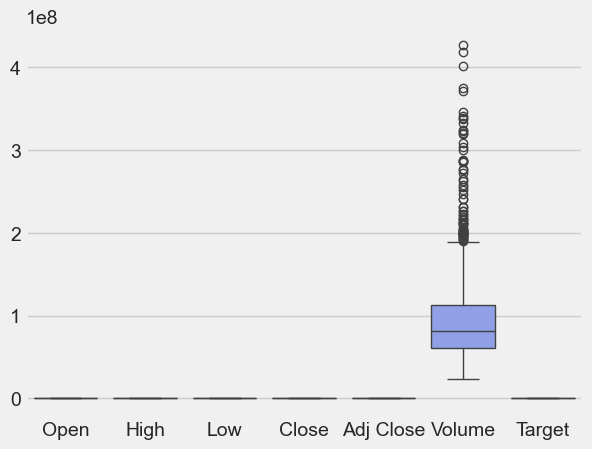

In [105]:
import seaborn as sns
sns.boxplot(data)

In [119]:
from scipy import stats

# Example DataFrame
data = df

# Ensure the data is numeric
numeric_data = data.select_dtypes(include=[np.number])

# Calculate z-scores
z_scores = stats.zscore(numeric_data)

# Identify outliers
outliers = (np.abs(z_scores) > 3)
            
# Print outliers
print("Outlier rows (True indicates an outlier):")
print(outliers)

Outlier rows (True indicates an outlier):
             Open   High    Low  Close  Adj Close  Volume
Date                                                     
2019-07-31  False  False  False  False      False    True
2019-08-01  False  False  False  False      False    True
2019-08-02  False  False  False  False      False   False
2019-08-05  False  False  False  False      False    True
2019-08-06  False  False  False  False      False   False
...           ...    ...    ...    ...        ...     ...
2024-07-25  False  False  False  False      False   False
2024-07-26  False  False  False  False      False   False
2024-07-29  False  False  False  False      False   False
2024-07-30  False  False  False  False      False   False
2024-07-31  False  False  False  False      False   False

[5036 rows x 6 columns]
